# Getting started

In [1]:
import pandas as pd 
import numpy as np
import pylab as py
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid", palette="deep")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier

import json
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
with open('credentials.json') as f:
    data = json.load(f)
    SPOTIPY_CLIENT_ID = data['SPOTIPY_CLIENT_ID']
    SPOTIPY_CLIENT_SECRET = data['SPOTIPY_CLIENT_SECRET']

spotify = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(SPOTIPY_CLIENT_ID, SPOTIPY_CLIENT_SECRET))

In [3]:
def get_playlist_ids(username,playlist_id):
    '''
    Returns all track IDs for a given playlist
    '''
    r = spotify.user_playlist_tracks(username,playlist_id)
    t = r['items']
    ids = []
    while r['next']:
        r = spotify.next(r)
        t.extend(r['items'])
    for s in t: ids.append(s["track"]["id"])
    return ids

In [4]:
playlist = get_playlist_ids('67433aedc8a2496c', '2H63hKSx2dJ3U7LRxKJlhZ')
playlist_features = pd.DataFrame(spotify.audio_features(playlist)).sample(frac=1.0, random_state=1).reset_index(drop=True)

In [5]:
playlist_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      99 non-null     float64
 1   energy            99 non-null     float64
 2   key               99 non-null     int64  
 3   loudness          99 non-null     float64
 4   mode              99 non-null     int64  
 5   speechiness       99 non-null     float64
 6   acousticness      99 non-null     float64
 7   instrumentalness  99 non-null     float64
 8   liveness          99 non-null     float64
 9   valence           99 non-null     float64
 10  tempo             99 non-null     float64
 11  type              99 non-null     object 
 12  id                99 non-null     object 
 13  uri               99 non-null     object 
 14  track_href        99 non-null     object 
 15  analysis_url      99 non-null     object 
 16  duration_ms       99 non-null     int64  
 17 

# Preprocessing

Much of the preprocessing methodology has been gleamed from experimenting with the '1 Million Track' dataset.

In [6]:
def preprocess_inputs(df):
    df = df.copy()
    
    # Change `duration_ms` to `duration_s`
    df['duration_s'] = df['duration_ms']/1000
    
    # Drop high-cardinality categorical columns and milliseconds column
    df = df.drop(['type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms'], axis=1)
    
    # Replace confidence measures in acousticness and instrumentalness with binary values
    for col in ["acousticness", "instrumentalness"]:
        df.loc[df[col] >= 0.5, col] = 1
        df.loc[df[col] < 0.5, col] = 0
        df[col] = df[col].astype("int32")
        print(f"Successfully made {col} binary")
    
    return df

In [7]:
X = preprocess_inputs(playlist_features)

Successfully made acousticness binary
Successfully made instrumentalness binary


In [8]:
X

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_s
0,0.661,0.713,0,-8.393,0,0.0723,0,0,0.367,0.433,124.005,4,117.347
1,0.791,0.267,5,-11.997,1,0.0415,1,1,0.102,0.544,165.990,4,215.111
2,0.438,0.495,1,-9.697,0,0.0742,0,0,0.160,0.778,166.851,5,212.966
3,0.577,0.747,11,-9.884,0,0.1830,0,0,0.175,0.713,158.853,4,76.347
4,0.233,0.933,6,-5.804,1,0.0572,0,1,0.101,0.420,95.972,3,191.320
...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,0.407,0.899,2,-6.238,1,0.1150,0,0,0.126,0.142,115.005,4,159.080
95,0.620,0.618,11,-7.480,0,0.0450,0,0,0.131,0.935,165.248,4,172.211
96,0.521,0.902,11,-6.876,0,0.0469,0,0,0.866,0.669,141.223,4,299.093
97,0.548,0.963,5,-4.320,1,0.0554,0,0,0.104,0.856,110.352,4,615.939


|Feature|Description|
|-------|-----------|
|dancability|Track suitability for dancing on a scale from 0.0 to 1.0|
|energy|The perceptual measure of intensity and activity on a scale from 0.0 to 1.0|
|key|The key the track is in from -1 to -11|
|loundness|Overall track loudness in decibels from -60dB to 0dB|
|mode|Modality of the track, either Major (1) or Minor (0)|
|speechiness|Presence of spoken words in the track on a scale from 0 to 1|
|acousticness|Confidence measure from 0 to 1 of weather the track is acoustic |
|instrumentalness|Weather a track contains vocals on a scale from 0.0 to 1.0|
|liveness|The presence of an audience in a recording on a scale from 0.0 to 1.0|
|valence|Musical positiveness on a scale from 0.0 to 1.0|
|tempo|Track tempo in beats per minute (BPM)|
|duration_s|Track duration in seconds|
|time_signature|Estimated time signature from 3 to 7|

# EDA

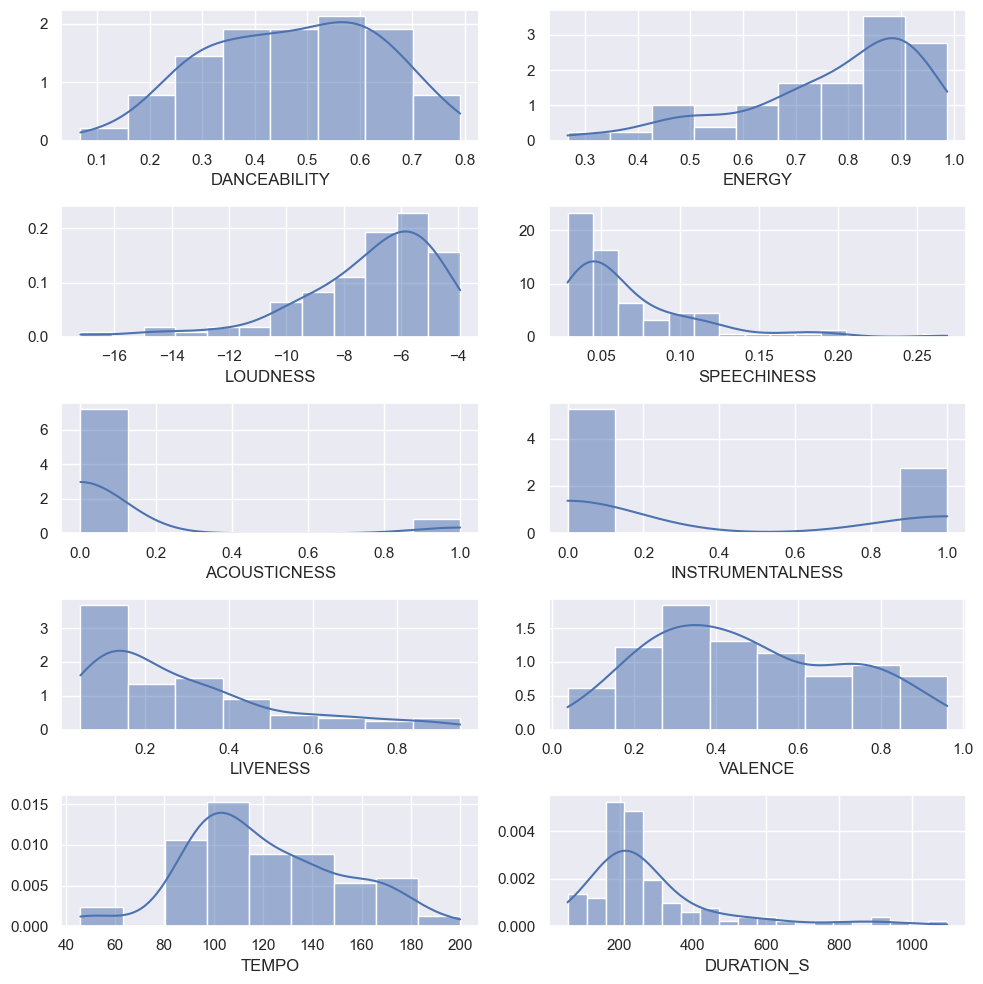

In [9]:
plt.figure(figsize=(10,10))

plt.subplot(5,2,1)
x = "danceability"
sns.histplot(data=X, x=x, kde=True, stat='density')
plt.ylabel("")
plt.xlabel(x.upper())

plt.subplot(5,2,2)
x="energy"
sns.histplot(data=X, x=x, kde=True, stat='density')
plt.ylabel("")
plt.xlabel(x.upper())

plt.subplot(5,2,3)
x="loudness"
sns.histplot(data=X, x=x, kde=True, stat='density')
plt.ylabel("")
plt.xlabel(x.upper())

plt.subplot(5,2,4)
x="speechiness"
sns.histplot(data=X, x=x, kde=True, stat='density')
plt.ylabel("")
plt.xlabel(x.upper())

plt.subplot(5,2,5)
x="acousticness"
sns.histplot(data=X, x=x, kde=True, stat='density')
plt.ylabel("")
plt.xlabel(x.upper())

plt.subplot(5,2,6)
x="instrumentalness"
sns.histplot(data=X, x=x, kde=True, stat='density')
plt.ylabel("")
plt.xlabel(x.upper())

plt.subplot(5,2,7)
x="liveness"
sns.histplot(data=X, x=x, kde=True, stat='density')
plt.ylabel("")
plt.xlabel(x.upper())

plt.subplot(5,2,8)
x="valence"
sns.histplot(data=X, x=x, kde=True, stat='density')
plt.ylabel("")
plt.xlabel(x.upper())

plt.subplot(5,2,9)
x="tempo"
sns.histplot(data=X, x=x, kde=True, stat='density')
plt.ylabel("")
plt.xlabel(x.upper())

plt.subplot(5,2,10)
x="duration_s"
sns.histplot(data=X, x=x, kde=True, stat='density')
plt.ylabel("")
plt.xlabel(x.upper())

plt.tight_layout()
plt.show()

In [10]:
X.to_csv("my_music_prepro.csv")

Next steps:
- Process 'Spotify 1 Million Tracks' data the same way as mine here.
- Insert new column `my_top` in both. It will take value `1` from this data, `0` from Million Tracks data.
- Predict if a song will be in `my_top` based on it's features.